In [60]:
import os
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
import pandas as pd
from datetime import date
from sklearn.model_selection import train_test_split

In [3]:
os.chdir('..')

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_51"; Java(TM) SE Runtime Environment (build 1.8.0_51-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.51-b03, mixed mode)
  Starting server from /Users/37138/anaconda3/envs/TEST/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/ff/0003j6g13lzcpwj4j090w7v9sr000f/T/tmplkmvy9fq
  JVM stdout: /var/folders/ff/0003j6g13lzcpwj4j090w7v9sr000f/T/tmplkmvy9fq/h2o_jpf_started_from_python.out
  JVM stderr: /var/folders/ff/0003j6g13lzcpwj4j090w7v9sr000f/T/tmplkmvy9fq/h2o_jpf_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Asia/Dubai
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,1 month and 26 days
H2O cluster name:,H2O_from_python_jpf_ae8aps
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [7]:
df = pd.read_csv('ENG_DATA/SELECTED/05-13_rf_all.csv', index_col = [0], parse_dates = ["sale_date"])

In [40]:
date1 = date(2015, 12, 31)

In [41]:
df.sort_values(by = 'sale_date', inplace=True)
df_train = df.query('sale_date <= @date1')
df_test, df_validate = train_test_split(df.query('sale_date > @date1'), test_size=0.5)

In [46]:
# Import a sample binary outcome train/test set into H2O
test = h2o.H2OFrame(df_test)
train = h2o.H2OFrame(df_train)
validate = h2o.H2OFrame(df_validate)

cols_cat = list(df_train.select_dtypes(exclude="number").columns)
cols_cat.remove("sale_date")
for col in cols_cat:
    train[col] = train[col].asfactor()
    test[col] = test[col].asfactor()
    validate[col] = validate[col].asfactor()

# Identify predictors and response
x = train.columns
y = "sale_price"
x.remove(y)
x.remove("sale_date")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [61]:
#
# Build and train the model:
grid_search_drf = H2ORandomForestEstimator()
# grid_search_gbm = H2OGradientBoostingEstimator(
#     stopping_rounds = 25,
#     stopping_metric = "AUC",
#     col_sample_rate = 0.65,
#     sample_rate = 0.65,
#     seed = RANDOM_STATE
# ) 

hyper_params = {
    'max_depth':[4,8,16,24],
    'ntrees':[50, 100, 250]}

grid = H2OGridSearch(grid_search_drf, hyper_params,
                         grid_id='depth_grid',
                         search_criteria={'strategy': "Cartesian"})
#Train grid search
grid.train(x=x, 
           y=y,
           training_frame=train,
           validation_frame=validate)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [65]:
drf = H2ORandomForestEstimator(
    ntrees=50, max_depth=16,
) 

In [66]:
drf.train(x=x,
          y=y,
          training_frame=train,
           validation_frame=validate)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [67]:
# Eval performance:
perf = drf.model_performance()

In [68]:
drf.r2(valid=True)

0.7230765188336598

In [69]:
drf.r2()

0.8129873633228035

In [78]:
# Generate predictions on a validation set (if necessary):
pred = drf.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


/Users/37138/anaconda3/envs/TEST/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'street_name' has levels not trained on: [Abbey St, Aladdin Ter, Alhambra St, Apollo , Balmy St, Bepler St, Bitting , Brewster , Cherry St, Cottage Row , Donner , Ellert St, Francisco , Funston St, Garnett Ter, Haight , Heather Ave, Hiliritas , Hollywood Ct, Hugo St, Ignacio Ave, Lamartine St, Langton St, Loma Vista Ter, Mendosa , Mercato Ct, Nadell Ct, Niantic Ave, Orben , Plymouth St, Raycliff Ter, Russian Hill Pl, Santa Ysabel Ave, Sharon St, Silverview , Thomas St, Upper Terrace Ter, Urbano St, Venus , West Portal , Winter Pl, Wood St, York ]
  warnings.warn(w)
/Users/37138/anaconda3/envs/TEST/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'drive_side' has levels not trained on: [PVSW,GRVL]
  warnings.warn(w)
/Users/37138/anaconda3/envs/TEST/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset colu

In [79]:
pred['sale_price'] = test['sale_price']

In [80]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
import numpy as np

In [83]:
df_pred = pred.as_data_frame()

In [84]:
df_pred

,predict,sale_price
0,4.317566e+06,3800000
1,1.836107e+06,1820000
2,1.966565e+06,2228000
3,5.075817e+06,6900000
4,1.727254e+06,2760000
...,...,...
3346,1.176101e+06,1300000
3347,1.070415e+06,1250000
3348,7.015312e+05,1050000
3349,7.349161e+05,728000


In [85]:
r2_score(df_pred["predict"], df_pred["sale_price"])

0.555298857535006

In [20]:
df_pred["pct_err"] = ((df_pred["predict"] - df_pred["sale_price"]) / df_pred["sale_price"]) *100

In [21]:
df_pred["pct_err"].describe()

count    4744.000000
mean        1.391958
std        13.047760
min       -65.284841
25%        -5.040566
50%         0.276401
75%         6.171786
max       321.612756
Name: pct_err, dtype: float64

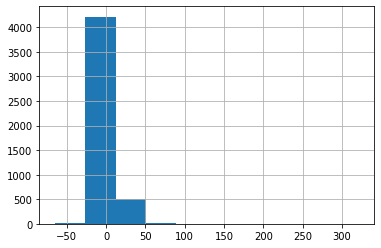

In [22]:
df_pred["pct_err"].hist()

In [90]:
df_pred.to_csv("ENG_DATA/PREDICTED/12-8_df_h20_leader_predictions.csv")

# Without List Price